In [1]:
using Pkg
Pkg.activate("EnvFerrite")
include("EITwithTV.jl")

  Activating project at `~/Code/Julia/FerriteStuff/Notebooks/Github/EnvFerrite`


update_Jr (generic function with 1 method)

# Electrical Impedance Tomography with TV Regularization

## Introduction

In this example we give a basic implementation of of the real valued Calderon problem relevant to Electrical Impedance Tomography. We will generate data and afterwards solve the inverse problem with a numerical solver and implement TV regularization.  

### Forward EIT:
Given a conductivity $\gamma: \Omega\subset\mathbb{R}^2 \rightarrow \mathbb{R}_{+}$ our solution $u\in H^1(\Omega,\mathbb{R}^2)$ (2D case) has to confirm to the equation:


$$ \nabla \cdot(\gamma\nabla u) = 0 \quad \forall x \in \Omega $$

For that equation we will choose a set of electrical current patterns 

$$ g_1, ..., g_n \in H^{-\frac{1}{2}}(\partial \Omega, \mathbb{R}) $$

such that:  

$$ \int_{\partial\Omega}g_i \, d\partial\Omega = 0 $$

to inject into the material via Neumann boundary conditions:

$$ \gamma\frac{\partial u_i}{\partial n} =g_i \quad \forall x \in \partial\Omega $$

In order to get the corresponding voltages 
$$ f_1, ..., f_n \in H^{\frac{1}{2}}(\partial \Omega, \mathbb{R}) $$
we will measure the corresponding voltage as:
$$ f_i := u_i|_{\partial\Omega} $$

with those boundary pairs $ (f_1,g_1), ... , (f_n,g_n) $ we now have an approximation of the Dirichlet to Neumann map:
$$ \Lambda_\gamma: H^{\frac{1}{2}}(\partial \Omega)\rightarrow H^{-\frac{1}{2}}(\partial \Omega) $$
This is called forward EIT since we just approximated the map:
$$ \gamma \rightarrow  \Lambda_\gamma $$

However real Electrical Impedance Tomography requires us to solve an **inverse Problem** where we have to reconstruct:
$$ \Lambda_\gamma \rightarrow  \gamma $$
for our approximation of $\Lambda_\gamma$ given by voltage-current boundary pairs $(f_i,g_i)$.

### Weak formulation
Given the strong formulation:
$$ \nabla \cdot(\gamma\nabla u) = 0 \quad \text{with Neumann BC:}\quad \gamma\frac{\partial u}{\partial n} = g $$

The weak formulation is:
$$ \int\limits_\Omega \gamma \nabla(u)\cdot\nabla(v) \, d \Omega = \int\limits_{\partial\Omega} g \,v \,d\partial\Omega  \quad \forall v\in H^1(\Omega)$$

### Inverse EIT
We will use $\gamma$ to refer to the true underlying conductivity and $\sigma$ for our current conductivity guess.
We will choose the simplest minimization functional for optimization:
$$ J_i(u_i,\sigma) = \| f_i- u_i\|^2_{\mathcal{L}^2(\partial\Omega)} = \int_{\partial\Omega}(f_i-u_i)^2 \,d\partial\Omega $$
In theory however we can plug in another metric or pseudo-metric like Wasserstein-distance or Spetral distance as mesure of distance between $f_i$ und $u_i$.
Such that our problem becomes:
$$ \underset{\sigma}{\min} \sum\limits_{i=1}^n J_i(u_i,\sigma) $$
such that:
$$ \nabla u_i\cdot(\sigma\nabla u_i) = 0\quad  \text{and Neumann BC}\quad \sigma\frac{\partial u_i}{\partial n} = g_i \quad \forall i\in\{1, ...,n\}$$
Given the problem our lagrangian becomes:
$$ \mathcal{L}(\sigma, u, \lambda) = \sum\limits_{i=1}^n\left( J_i(u_i,\sigma) + \langle \lambda_i, \nabla\cdot(\sigma\nabla u_i) \rangle_{\mathcal{L}^2(\Omega)}   \right) $$

from this we will use [Adjoint state methods](https://en.wikipedia.org/wiki/Adjoint_state_method#General_case) to calculate the gradient.
Without stating any of the steps of the derivation we end up with:
- State Equation (Variation with $\delta_\lambda$)
$$ \nabla \cdot(\sigma\nabla u_i) = 0\quad  \text{with Neumann BC}\quad \sigma\frac{\partial u_i}{\partial n} = g_i$$

- Adjoint Equation (Variation with $\delta_u$)
$$ \nabla \cdot(\sigma\nabla\lambda_i) = 0\quad  \text{with Neumann BC}\quad \sigma\frac{\partial \lambda_i}{\partial n} = 2(u_i-f_i)$$
- Functional Derivative (Variation with $\delta_\sigma$)
$$ \delta_i\sigma = -\nabla u_i \cdot \nabla \lambda_i $$

#### Total Variation (TV) regularization
for real world examples and numerical stability we have to assume that our system contains some noise, like $f = f_{true} + \epsilon$. Since the inverse EIT problem is highly ill conditioned we have to consider regularization.


Because $|\nabla\sigma|^2$ is non-differentiable when $\nabla\sigma=0$, we use
$$
\mathcal{R}_{TV}(\sigma) = \int_\Omega \sqrt{|\nabla\sigma|^2+\eta}\, d\Omega,
$$
and the gradient:
$$ \delta_\sigma\mathcal{R}= -\nabla\cdot \left(   \frac{\nabla\sigma}{\sqrt{|\nabla \sigma|^2+ \eta}} \right) $$
with a small $\eta$ to revent division by zero.
This is a $L^2$ projection that requires us to sove the weak form.
##### Weak formulation of TV Regularizer:
$$ \int_\Omega wv \,d\Omega = \int_\Omega \frac{\nabla(\sigma)}{\sqrt{|\nabla\sigma|^2+\eta}}\cdot\nabla(v)\, d\Omega \quad \forall v\in FESpace$$


### Full reconstruction Algorithm (Conceptual)
+ Preallocate Massmatrix M and L^2 projector (Cholesky factorization)
+ Start with conductivity guess $\sigma_0$ (In our case: $\sigma_0(x) = 1.0$)
+ Preallocate & initialize Conjugate Gradient(CG) solver for $u_1, ...,u_n.\lambda_1,.., \lambda_n,w$.
+ Repeat till tolerance is reached or other stopping condition:
    + From $\sigma_t$ assemble stiffness matrix $K_{\sigma_t}$
    + for all $i = 1, ...,n$ (in parallel)
        + Calculate $u_i$ (State equation) as well as the $\mathcal{L}^2(\partial\Omega)$ error: $\delta u_i$
        + Calculate $\lambda_i$ (Adjoint equation)
        + Calculate $\delta\sigma_i$ (Functional derivative)
    + Calculate TV Regularization gradient and error.
    + Update $\sigma_{t+1} = \sigma_t +\beta\, \delta_{TV}\sigma + \sum_{i=1}^n \alpha_i\,\delta_i\sigma $ (with Gauss-Newton with Levenberg-Marquardt).

## Implementation
### Preliminaries
Obvious Imports:

In [2]:
using Ferrite
using SparseArrays
using LinearAlgebra
using Revise
using Interpolations
using Plots
using Statistics
using IterativeSolvers
using LinearMaps

For simplicity we will use a quadratic grid with quadrilateral elements. We are using Quadrilaterals for now:

In [3]:
grid = generate_grid(Quadrilateral, (16, 16));
dim = Ferrite.getspatialdim(grid)
order = 1
qr_order = 2

ip = Lagrange{RefQuadrilateral, order}()
qr = QuadratureRule{RefQuadrilateral}(qr_order)
qr_face = FacetQuadratureRule{RefQuadrilateral}(qr_order)
cellvalues = CellValues(qr, ip)
facetvalues = FacetValues(qr_face, ip)

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh)



∂Ω = union(getfacetset.((grid,), ["left", "top", "right", "bottom"])...)
length(∂Ω)

64

For later use we will assemble and cholesky decompose the mass matrix once.

In [4]:
# This is supposed to be: ∫(u*v)dΩ and it's Cholesky decomposition
M, MC = assemble_M(cellvalues,dh)

(sparse([1, 2, 3, 4, 1, 2, 3, 4, 5, 6  …  270, 271, 272, 287, 288, 289, 271, 272, 288, 289], [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  288, 288, 288, 288, 288, 288, 289, 289, 289, 289], [0.001736111111111111, 0.0008680555555555556, 0.00043402777777777775, 0.0008680555555555555, 0.0008680555555555556, 0.0034722222222222225, 0.001736111111111111, 0.00043402777777777775, 0.0008680555555555556, 0.00043402777777777775  …  0.00043402777777777775, 0.001736111111111111, 0.00043402777777777765, 0.0008680555555555553, 0.003472222222222221, 0.0008680555555555553, 0.00043402777777777765, 0.0008680555555555553, 0.0008680555555555553, 0.0017361111111111106], 289, 289), SparseArrays.CHOLMOD.Factor{Float64, Int64}
type:    LLt
method:  simplicial
maxnnz:  3815
nnz:     3815
success: true
)

Furthermore we want to know which entries of the force vector correspond to the boundary:
We will get:
- the count of nonzero entries in the force vector
- the position of non zero entries
- a function "up" to cast a vector of length of boundary dofs into the length of the force vector
- a function "down" to cast a vector into the length of the dofs of the force vector that lay on the boundary.

Note: depending on the grid and the method used this can be more complicated up and down function.
I want to from the start take a very modular approach where one can plugin different methods, even Spectral Methods instead of FEM and the Code might be reusable. That is why in some cases up and down wouldn't be a simple function in vector indices but a full blown operator.

In [5]:
nzc,nzpos, down, up = produce_nonzero_positions(facetvalues, dh,∂Ω)
@assert nzc == length(∂Ω)  # This is not true in Gridap.jl

In [6]:
## Sanity check:
# I have never questioned the assumption that up∘down == id and down∘up == id. Maybe I should check this.
test_vec = [i for i in 1:nzc]
@assert down(up(test_vec)) == test_vec
@assert up(down(up(test_vec))) == up(test_vec)

### Data generation

Now we will make up some conductivity. As well as some current patterns:

In [7]:
conductivity  = (x) -> 1.1 + sin(x[1]) * cos(x[2])

#23 (generic function with 1 method)

For later we want to project that function unto Q1 FE space for that we want to assemble the coefficients in the FESpace:

In [8]:

cond_vec = assemble_function_vector(cellvalues, dh, conductivity, M)

289-element Vector{Float64}:
 0.644152684736913
 0.6841903492627199
 0.6067266487628111
 0.559230125001669
 0.7307312974358627
 0.6619379923052616
 0.7830306178396268
 0.7239804701487873
 0.84027719579124
 0.7918918601393378
 ⋮
 1.099999999999999
 1.1675409945091269
 1.23402802933429
 1.2984236218057983
 1.3597228042087597
 1.4169693821603724
 1.4692687025641376
 1.5158096507372794
 1.5558473152630885

In [9]:
# This function assembles the stiffness matrix from a given vector.
# This is: ∫(γ * ∇(u)⋅∇(v))dΩ 
K_from_vec = assemble_K(cellvalues, dh,cond_vec)

289×289 SparseMatrixCSC{Float64, Int64} with 2401 stored entries:
⎡⠻⣦⡀⠀⠐⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⡀⠘⣧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠰⣤⣀⠈⠻⣦⡘⢶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠉⠛⢲⣌⠻⣦⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣌⠻⢆⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⣦⡙⢦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⣦⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠳⣌⠻⣦⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠱⣦⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⣦⡙⢶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢳⣌⠻⣦⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⢆⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⣦⡙⢦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⣦⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠳⣌⠻⣦⡙⢦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠱⣦⡙⢦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⣦⡙⢦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⣦⡙⢦⡀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣌⠻⢆⡙⠦⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⡌⠻⣦⎦

In [10]:
# This is matrix assembly on a function. How do I do it if the conductivity is given as a coefficient vector for Q1 FE Space?
# This is: ∫(γ * ∇(u)⋅∇(v))d
K_true = assemble_K(cellvalues, dh, conductivity)
K_true_LU = factorize(K_true)

SparseArrays.CHOLMOD.Factor{Float64, Int64}
type:    LDLt
method:  simplicial
maxnnz:  3815
nnz:     3815
success: true


In [11]:
# Sanity check: (positive semidefinite self adjoint stiffness matrix)
@assert K_true == K_true'  # Not true in Gridap.jl
if ndofs(dh) < 500
    K_dense = Matrix(K_true)
    eig_min = minimum(eigvals(K_dense))
    @assert eig_min > -1e-14
    print("Smallest eigenvalue: ", eig_min)
end

Smallest eigenvalue: -1.94652976991602e-16

Now we generate current patterns: We assume one current source and one current sink. Important is that it sums of to zero.
We generate the right hand side force vectors $g_1, ... g_n$ as an Matrix G and calculate $f_1, ..., f_n$

In [12]:
num_modes = Int64((nzc^2-nzc)//2)
G_small = zeros(nzc,num_modes)
G = zeros(ndofs(dh),num_modes)
k = 1
for i in 1:(nzc-1)
    for j in i+1:nzc
        G_small[i,k] = 1.0
        G_small[j,k] = -1.0
        G[:,k] = up(G_small[:,k])
        k += 1
    end
end
F_big = K_true_LU \ G
F = zeros(nzc,num_modes)
k = 1
for i in 1:(nzc-1)
    for j in i+1:nzc
        F[:,k] = down(F_big[:,k])
        k += 1
    end
end
col_means = mean(F, dims=1)
F .-= col_means

64×2016 Matrix{Float64}:
  2.30292     2.26394      2.90952     3.30183    …   0.0163961   0.00897954
 -0.812527    0.109923     0.497171    0.924775       0.0163502   0.0089682
  0.148901   -0.980469     0.710295    1.0545         0.0164435   0.00899124
 -0.109424    0.0647217   -0.997809    0.143253       0.0162173   0.00893539
 -0.0741391   0.016607    -0.249065   -1.11555        0.0160037   0.00888259
 -0.0512821   0.00063017  -0.162015   -0.350418   …   0.0157158   0.00881137
 -0.0422296  -0.00745448  -0.118149   -0.239163       0.0153609   0.00872349
 -0.0374468  -0.011809    -0.0976012  -0.181881       0.0149479   0.00862104
 -0.0347296  -0.0143707   -0.0861511  -0.153069       0.0144873   0.00850662
 -0.0330712  -0.0159639   -0.0793021  -0.13635        0.0139928   0.00838351
  ⋮                                               ⋱               ⋮
 -0.0276973  -0.0213465   -0.0578673  -0.0872506  …   0.0356959   0.0136314
 -0.027882   -0.0211539   -0.0585805  -0.0887961      0.040147

To be realistic we will add some noise:
We have to ensure that our noise has mean zero.

In [13]:
function mean_zero_noise(n::Int64, σ::Float64)
    out = σ * randn(n)
    mean = Statistics.mean(out)
    out .- mean
end

mean_zero_noise (generic function with 1 method)

To simplify things we can also do SVD:

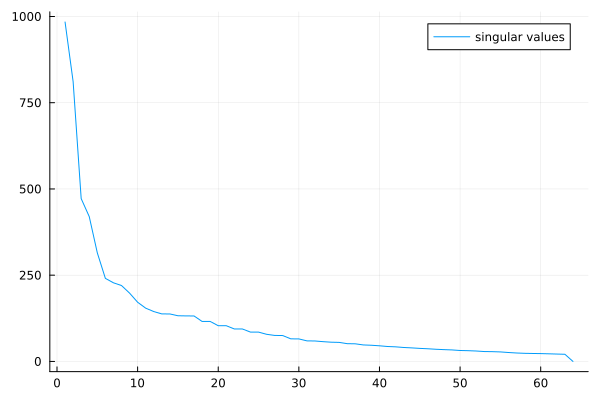

In [14]:
# reduce the number of modes according to used SVD modes

# This SVD implementation is not correct
F, Σ, G_small, Λ, num_modes = do_svd(F,G_small)
# Apply singular Values:
G = zeros(ndofs(dh),num_modes)
F_big = copy(G)
for i in 1:num_modes
    G[:,i] = up(G_small[:,i])
    
end
F_Big  = K_true \ G
for i in 1:num_modes
    F[:,i] = down(F_big[:,i])
end
# We can also plot the singular values
plot(Σ, label = "singular values")


In [15]:
# Do sanity check of where you did svd right.
norm_svd = norm((K_true \ G[:,1]) - F_big[:,1] )
println(norm_svd)
@assert norm_svd < 1e-4

22.68248051718396


AssertionError: AssertionError: norm_svd < 0.0001

now that we have done SVD on the original choice of modes we have 
- Truncation of SVD modes, thus regularization
- Averaging of noise over multiple measurements
- Elimination of any unncessary number of nodes we choose before.

Here we define a struct where we save and preallocate all the necessary information for the solver step.

In [16]:
# Implement a sanity check if the two matrices assembled from the function and the vector are roughly the same (use relatively coarse ≈ )
Matrix_norm = norm(K_from_vec - K_true)
println("Norm of Matrix difference: ",Matrix_norm)
@assert Matrix_norm < 20.0

g_test = G[:,1]
f_test_true = K_true \ g_test
f_test_vec = K_from_vec \g_test
vector_norm = norm(f_test_true - f_test_vec)
println("norm of difference of first SVD mode: " ,vector_norm)
@assert vector_norm < 13.0

Norm of Matrix difference: 5.028543617854563e-5
norm of difference of first SVD mode: 9.282892071218507


In [17]:
mode_dict = Dict{Int64,EITMode}()
for i in 1:num_modes
    mode_dict[i] = EITMode(G[:,i],F[:,i])
end

### Solving EIT

We will now assume a starting conductivity guess $\sigma_0(x) = 1.0 $

In [18]:
σ₀ = (x) -> 1.0

#25 (generic function with 1 method)

We would prefer to save $\sigma$ as a vector for use in FEM and also have a method to export each

In [19]:
# Project function here: 
σ = assemble_function_vector(cellvalues,dh, σ₀, MC)


289-element Vector{Float64}:
 1.0
 1.0000000000000004
 0.9999999999999998
 1.0
 0.9999999999999992
 1.0
 1.0000000000000007
 0.9999999999999992
 0.9999999999999998
 1.0000000000000002
 ⋮
 0.9999999999999992
 1.0000000000000007
 0.9999999999999992
 1.0000000000000004
 1.0000000000000002
 0.9999999999999999
 1.0000000000000009
 1.0000000000000002
 1.0000000000000004

A prerequisite is that we can calculate the bilinear map: $\nabla(u)\cdot\nabla(\lambda)$


In [20]:
# Assemble right-hand side for the projection of ∇(u) ⋅ ∇(λ) onto the FE space.
# This computes rhs_i = ∫ (∇u ⋅ ∇λ) ϕ_i dΩ for each test function ϕ_i.
# Assuming u and λ are scalar fields in the same FE space.
# cellvalues should be CellScalarValues(qr, ip) where qr is QuadratureRule, ip is Interpolation.
#function calculate_bilinear_map(a::AbstractVector, b::AbstractVector, cellvalues::CellValues, dh::DofHandler, M_cholesky)
# Write some code which demonstrates this function:


Here we define which metric we want to use:
In our case we will stick with the squared $L^2$ metric, but in theory one would receive more stable EIT reconstruction if instead one calculates Wasserstein distance, Spectral distances or similar.

In [21]:
# Here we define the metric we will use:
d = (x,y) -> norm(x-y)^2
∂d = (x,y) -> 2*(x-y) 
# This allows us to plugin other metrics and differentiate with Enzyme:
# define metric here:

# define other metric here:
#d = (x, y) -> ...
# We can now use Enzyme or Zygote Autodiff library:
using Enzyme
makegradₓ(d) = (x, y) -> Enzyme.gradient(Reverse, Const(d), x, y)[1]
∂ₓd = makegradₓ(d)
# Sanity test, whether this is working:
a = randn(10)
b = randn(10)
#@assert norm(∂d(a,b) - ∂ₓd(a,b)) ≈ 0

10-element Vector{Float64}:
  1.6039347750939497
 -1.1504669534974796
 -1.1889612819772641
 -0.5285991587839316
  1.4483366570252052
 -0.9968910252544546
 -0.5900732798375271
  0.5132523069667463
  0.2788413249267226
  0.7946426192273629

With the given matrix and projector our we need to solve for every mode $(f_i,g_i)$ the adjoint-state-solution to get the gradient:

$$ \nabla_\sigma d(K_\sigma\; g_i,f_i) $$
with $d(\cdot,\cdot)$ being some pseudo metric through which we measure the error and $K_\sigma$ the Forward EIT operator dependent on $\sigma$
Our implementation becomes:
```julia
function state_adjoint_step!(mode::EITMode, K_factorized, M, d,∂d ,down,up,dh::DofHandler, cellvalues::CellValues)
    # We solve the state equation ∇⋅(σ∇uᵢ) = 0 : σ∂u/∂𝐧 = g
    mode.u = K \ mode.g
    # Projection from down:Ω → ∂Ω
    b = down(mode.u) 
    # Normalize: ∫(uᵢ)d∂Ω = 0
    mean = Statistics.mean(b) 
    b .-= mean
    mode.u .-= mean 
    # We solve the adjoint equation ∇⋅(σ∇λᵢ) = 0 : σ∂u/∂𝐧 = ∂ₓd(u,f)
    mode.λ = K \ up(∂d(b,mode.f)) 
    # Note: we have projection up: ∂Ω → Ω (fill in zeros)
    # ∂ₓd is gradient of pseudo metric d(x,y)
    mode.error = d(b,mode.f) # Error according to pseudo metric d(x,y)
    # Calculate ∇(uᵢ)⋅∇(λᵢ) here: 
    mode.δσ = calculate_bilinear_map(mode.λ, mode.u, cellvalues, dh, M) 
end
```
For efficiency we will use a Conjugate Gradient (CG) solver in production.

In [22]:
# For comparison to adjoint-state-method implement gradient based on Autodiff here:
# we need to define assemble an optimization functional:

function assemble_optimization_functional(cellvalues::CellValues,dh::DofHandler,up,down,d)
    return (σ,f,g) -> begin
        K = assemble_K(cellvalues,dh,σ,1e-12)
        # enforce main zero
        f .-= Statistics.mean(f)
        b = up(g)
        b .-= Statistics.mean(b)
        u = down(K \ b)  # This is the problematic part for using Autodiff
        #maybe enforce main zero again:
        error = d(u,f)
        return error
    end
end
J_func = assemble_optimization_functional(cellvalues,dh,up,down,d)

# now in the next step we need to use autodiff:

makegrad_σ(J) = (σ, f, g) -> Enzyme.gradient(Reverse, Const(J), σ, f, g)[1]

∂σJ = makegrad_σ(J_func)


#35 (generic function with 1 method)

Thus we have assembled the gradient for a mode using Enzyme Autodiff: 
Let's try whether it works.

In [23]:
# Don't try for now
# ∂σJ(σ, mode_dict[1].f, down(mode_dict[1].g))

No it doesn't

It get's a little bit more complicated than I thought and I already asked in the forum.

### Regularization
#### Tikhonov Regularization
For Tikhonov regularization we already have assembled:

In [24]:
# This is: ∫(∇(u)⋅∇(v))dΩ the stiffness matrix without specified coefficients. It is used for Tikhonov H¹ regularization. 
K_st , K_TK = assemble_K(cellvalues, dh)

(sparse([1, 2, 3, 4, 1, 2, 3, 4, 5, 6  …  270, 271, 272, 287, 288, 289, 271, 272, 288, 289], [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  288, 288, 288, 288, 288, 288, 289, 289, 289, 289], [0.6666666666666663, -0.16666666666666646, -0.3333333333333332, -0.16666666666666663, -0.16666666666666646, 1.3333333333333326, -0.3333333333333331, -0.3333333333333332, -0.16666666666666652, -0.33333333333333315  …  -0.3333333333333333, -0.3333333333333333, -0.33333333333333315, -0.1666666666666666, 1.333333333333333, -0.16666666666666657, -0.33333333333333326, -0.16666666666666663, -0.16666666666666657, 0.6666666666666665], 289, 289), SparseArrays.CHOLMOD.Factor{Float64, Int64}
type:    LLt
method:  simplicial
maxnnz:  3815
nnz:     3815
success: true
)

In [25]:
mutable struct FerriteEITProblem
    M # Massmatrix ∫(ϕᵢϕⱼ)dΩ as Sparse matrix
    MC # Massmatrix Cholesky 
    KST # Stiffness matrix ∫(∇ϕᵢ⋅∇ϕⱼ)dΩ of the mesh
    up # Projection to boundary (Can be an operator)
    down # Projection from boundary to force vector
    d # the metric we are using for the problem
    ∂d # the metric d(x,y) differentiated after x
    σ # The current guess of the conductivity
    K # The current guess of the stiffnessmatrix ∫(σ*∇ϕᵢ⋅∇ϕⱼ)dΩ assembled from σ
    Kfac # factorized version of guess of stiffness matrix
    cellvalues::CellValues
    dh::DofHandler
    n::Int64 # ndofs(dh)
end
K_σ = assemble_K(cellvalues,dh,σ)

data = FerriteEITProblem(M,MC,K_st,up,down, d, ∂d, σ, K_σ, factorize(K_σ),cellvalues,dh,ndofs(dh))

FerriteEITProblem(sparse([1, 2, 3, 4, 1, 2, 3, 4, 5, 6  …  270, 271, 272, 287, 288, 289, 271, 272, 288, 289], [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  288, 288, 288, 288, 288, 288, 289, 289, 289, 289], [0.001736111111111111, 0.0008680555555555556, 0.00043402777777777775, 0.0008680555555555555, 0.0008680555555555556, 0.0034722222222222225, 0.001736111111111111, 0.00043402777777777775, 0.0008680555555555556, 0.00043402777777777775  …  0.00043402777777777775, 0.001736111111111111, 0.00043402777777777765, 0.0008680555555555553, 0.003472222222222221, 0.0008680555555555553, 0.00043402777777777765, 0.0008680555555555553, 0.0008680555555555553, 0.0017361111111111106], 289, 289), SparseArrays.CHOLMOD.Factor{Float64, Int64}
type:    LLt
method:  simplicial
maxnnz:  3815
nnz:     3815
success: true
, sparse([1, 2, 3, 4, 1, 2, 3, 4, 5, 6  …  270, 271, 272, 287, 288, 289, 271, 272, 288, 289], [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  288, 288, 288, 288, 288, 288, 289, 289, 289, 289], [0.6666666666666663, -0.16666

#### TV regularization
Additinal we need to assemble the TV regularizer. The required Mass matrix we already have asembled and ready to use. 


In [26]:
tv = TV(ndofs(dh))
calc_tv_gradient!(σ, tv, cellvalues, dh, M)

([3.2219057382748446e-5, -5.5837278817624385e-5, 2.9253189530590552e-5, -1.8051404214503544e-5, 6.484513822018395e-5, -2.8222108224870155e-5, -8.610747062329395e-5, 7.147228209540172e-5, 2.456791931597707e-5, -5.1399905724473835e-5  …  -0.00010674461553114132, 0.00011792914925923239, -0.00012265048442922566, 0.00010670360584536778, -6.967845921681451e-5, -8.8930279044426e-6, 3.994279299669547e-5, -6.645346147552027e-5, -1.321517380557987e-5, -2.919033726277597e-5], 1.0000000000002386e-8)

For finding suitable stepsizes we will use Gauss-Newton.
Since we want to avoid implementing a dense Hessian Matrix we use SVD to invert the Matrix.

In [27]:
# Later I might want to do Split-Bregman

#=
using LinearAlgebra

# Forward operator: F(γ) -> simulated boundary voltages
function forward(γ)
    # placeholder: replace with your FEM/EIT solver
    return γ # dummy
end

# Residual: r(γ) = F(γ) - y
function residual(γ, y)
    return forward(γ) - y
end

# Gradient of data term (Jacobian): ∇_γ 0.5*||F(γ)-y||^2
function grad_data(γ, y)
    # placeholder: replace with actual Jacobian * residual
    return residual(γ, y)
end


# That are the exact axoims the proximal operator has to fullfill?
# Example proximal operator: soft-thresholding (for L1 norm)
function prox_l1(x, λ)
    return sign.(x) .* max.(abs.(x) .- λ, 0)
end

# Split Bregman iteration
function split_bregman(γ0, y; λ=1.0, μ=1.0, niter=20, prox=prox_l1)
    γ = copy(γ0)
    d = zeros(size(γ0))
    b = zeros(size(γ0))
    
    for k in 1:niter
        # --- Update γ (data term + quadratic penalty) ---
        # Solve: min 0.5||F(γ)-y||^2 + μ/2 ||∇γ - d - b||^2
        # Here we do a simple gradient descent for illustration
        g = grad_data(γ, y) + μ * (γ - d - b) # replace ∇γ with identity for simplicity
        γ -= 0.1 * g # step size 0.1, tune for your problem
        
        # --- Update auxiliary variable d (prox of regularizer) ---
        d = prox(γ + b, λ/μ)
        
        # --- Update Bregman variable ---
        b += γ - d
    end
    
    return γ
end
=#

In [28]:
mutable struct OptParam
    τ::Float64 # Stepsize for update σ += τ * δσ
    maxiter::Int64 # Max iterations for CG solver
    ϵ::Float64 # This is K + ϵI to ensure positive definiteness
    num_modes::Int64 # number of modes for truncated SVD  
    β_LM::Float64 # For Levenberg marquadt optimization
    do_TV::Bool # Whether one does TV regularization or not.
    β_TV::Float64 # For TV optimization
end

In [29]:
opt = OptParam(0.1,500,0.0,num_modes,1e-3,false,0.0)

OptParam(0.1, 500, 0.0, 63, 0.001, false, 0.0)

In [30]:
# This function will not check for mismatches and assume everything is properly initialized:
function gauss_newton_step!(data::FerriteEITProblem, modes::Dict{Int64,EITMode}, gn::GaussNewtonState, opt::OptParam)
    # Assemble new matrix
    data.K = assemble_K(data.cellvalues,data.dh,data.σ)
    # Check if dimensionality of J and r fits modes. Else change:
    gn.J = zeros(opt.num_modes,data.n)
    gn.δ = zeros(opt.num_modes)
    #=if do_TV  # Think about this later.
        tv_task = Threads.@spawn begin
            calc_tv_gradient!(σ,tv, dh,cellvalues,M)
        end
    end =#
    # This is the calculation of the gradient 
    Threads.@threads for i in 1:opt.num_modes
        state_adjoint_step_cg!(mode_dict[i], data.K, data.M,  data.d,data.∂d , data.down, data.up, data.dh, data.cellvalues)
    end
    # Now we will fetch the TV task:
    #=if do_TV
        fetch(tv_task) 
    end =#
    for i in 1:opt.num_modes
        gn.J[i,:] = modes[i].δσ
        gn.r[i] = modes[i].error
    end

    δσ = gauss_newton_svd!(gn,  opt.β_LM)
    #δσ = gauss_newton_cg!(gn,  opt.β_LM)
    # update σ
    data.σ .+= opt.τ * gn.δ
    data.σ .= max.(data.σ ,1e-12) # Ensure positivity
    
    return gn.δ
end
    

gauss_newton_step! (generic function with 1 method)

In [31]:
gn = GaussNewtonState(data.n,num_modes)

GaussNewtonState([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 289×289 LinearMaps.WrappedMap{Float64} of
  289×289 SparseMatrixCSC{Float64, Int64} with 289 stored entries)

In [46]:
data.σ = ones(data.n)
σ =data.σ

289-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [47]:
σ_prev = copy(σ)
error  = norm(cond_vec - σ)
println("With error: ", error)
error2  = norm(K_st*(cond_vec - σ))
println("With H^1 error: ", error2)

With error: 7.989185663754735
With H^1 error: 0.5060961398090454


In [48]:
δσ = gauss_newton_step!(data, mode_dict, gn, opt)

289-element Vector{Float64}:
 0.001922300601579802
 0.003946378718037947
 0.007710338734752156
 0.004125692429028915
 0.003919970378572728
 0.008373655068694344
 0.003998795498203363
 0.008540482445115752
 0.003955440552087744
 0.0075086741098083
 ⋮
 0.0039407412975043625
 0.003960383451973935
 0.003914898171831497
 0.003950617293679684
 0.0038970077107763927
 0.00389808830631411
 0.0038600044296450034
 0.003918540379995107
 0.0019356819843076968

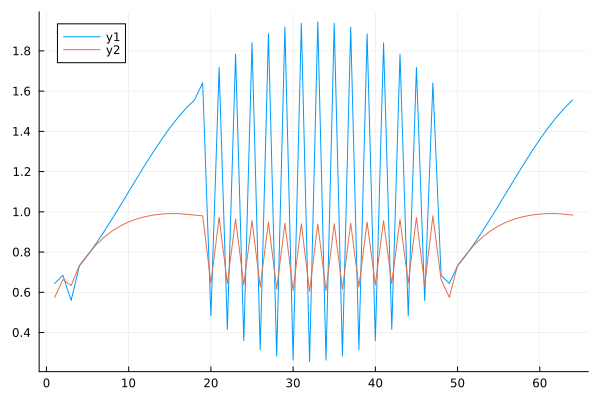

In [62]:
# Sanity check whether 
plot(down(cond_vec))
plot!(1 .- 0.002*down(mode_dict[1].δσ))

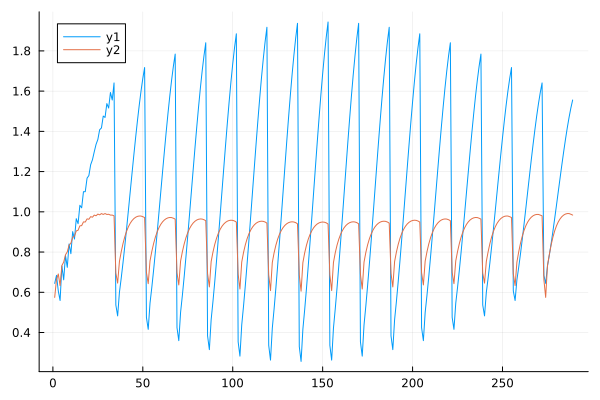

In [63]:
plot(cond_vec)
plot!(1 .- 0.002*mode_dict[1].δσ)

Now that we have all the pieces we can assemble the full optimization step:

In [37]:
σ_prev = copy(σ)
error  = norm(cond_vec - σ)
println("With error: ", error)

With error: 7.986677261004688


Let's run this optimization loop a few times:

In [38]:
#opt.num_modes = 20 # Truncate with SVD
for i in 1:10
    println("Step ", i, " ")
    result, time, bytes, gctime, memallocs = @timed begin
        δσ = gauss_newton_step!(data, mode_dict, gn, opt)
        #δσ, _ = cheat_step!(MC, cond_vec, σ, mode_dict, 10, tv,  d,∂d ,down,up,dh, cellvalues, false)
    end
    #println("Time: ", time, " seconds, Bytes: ", bytes, ", GC time: ", gctime, ", Memory allocations: ", memallocs)
    error  = norm(cond_vec - σ)
    println("With error: ", error)
    error2  = norm(K_st*(cond_vec - σ))
    println("With H^1 error: ", error2)
    step_param = dot((σ_prev - cond_vec), δσ )
    σ_prev = copy(σ)
    println("And ideal step multiplier: ",step_param)
end

Step 1 
With error: 7.984184561599305
With H^1 error: 0.50637203808822
And ideal step multiplier: -0.19978611202750074
Step 2 
With error: 7.9817076200503125
With H^1 error: 0.5065634978112254
And ideal step multiplier: -0.19846732876591333
Step 3 
With error: 7.979246490907275
With H^1 error: 0.5067907054402345
And ideal step multiplier: -0.1971453654523047
Step 4 
With error: 7.976801228764792
With H^1 error: 0.5070537072768629
And ideal step multiplier: -0.19582021638299996
Step 5 
With error: 7.974371888261604
With H^1 error: 0.5073525421218806
And ideal step multiplier: -0.1944918758450509
Step 6 
With error: 7.971958524079685
With H^1 error: 0.5076872412675368
And ideal step multiplier: -0.19316033811623803
Step 7 
With error: 7.969561190943333
With H^1 error: 0.5080578284978324
And ideal step multiplier: -0.19182559746496267
Step 8 
With error: 7.967179943618248
With H^1 error: 0.5084643200967118
And ideal step multiplier: -0.1904876481503553
Step 9 
With error: 7.96481483691061

Let's try some Tikhonov Regularization:

In [39]:
gn.M = LinearMap(0.5*I + 0.2*M + 0.3*K_st)

289×289 LinearMaps.WrappedMap{Float64} of
  289×289 SparseMatrixCSC{Float64, Int64} with 2401 stored entries

In [40]:
#opt.num_modes = 20 # Truncate with SVD
for i in 1:5
    print("Step ", i, " ")
    result, time, bytes, gctime, memallocs = @timed begin
        δσ = gauss_newton_step!(data, mode_dict, gn, opt)
        #δσ, _ = cheat_step!(MC, cond_vec, σ, mode_dict, 10, tv,  d,∂d ,down,up,dh, cellvalues, false)
    end
    #println("Time: ", time, " seconds, Bytes: ", bytes, ", GC time: ", gctime, ", Memory allocations: ", memallocs)
    error  = norm(cond_vec - σ)
    println("With error: ", error)
    error2  = norm(K_st*(cond_vec - σ))
    println("With H^1 error: ", error2)
    step_param = dot((σ_prev - cond_vec), δσ )
    σ_prev = copy(σ)
    println("And ideal step multiplier: ",step_param)
end

Step 1 With error: 7.960133264769227
With H^1 error: 0.5098992718361178
And ideal step multiplier: -0.18645449067728997
Step 2 With error: 7.95781690914183
With H^1 error: 0.5104493944747966
And ideal step multiplier: -0.18510364911325108
Step 3 With error: 7.955516913742697
With H^1 error: 0.5110353912366113
And ideal step multiplier: -0.18374957004094805
Step 4 With error: 7.953233333566316
With H^1 error: 0.5116572340142838
And ideal step multiplier: -0.18239224766318698
Step 5 With error: 7.950966223641976
With H^1 error: 0.5123148874743945
And ideal step multiplier: -0.18103167617333962


## Plotting (To be done)


In [41]:
# project is to grid and plot with Plots.jl
# I wanna use Plots.jl and not Makie.jl or similar because lateron i want to implement a NN on the grid as a regularizer using Lux.jl

In [42]:
# Project to dictionary (coordinate,value)
#PointEvalHandler(grid, points::AbstractVector{Vec{dim,T}})
# Put values from dictionary into Array.

This is our original and final reconstruction:

In [43]:
# Plot reconstruction and original with Plots.jl here